## Phys Astro Data: Deep Learning using Pytorch and Keras

Objectives:
* Explain the essential components behind training a neural network
* Show simple practical example of how to program a neural network
* Contrast the two leading frameworks (Pytorch and Keras) so that people can make an informed decision.
* Try and make it useful for people who already know machine learning (with small links to papers and asides).

We will only talk about neural networks (ie deep learning) as this is what these libraries are specialized for.

### Neural Network Basics

Machine learning = learning from examples.

Let us begin with an example, consider we have a dataset containing images of digits as well as their **labels**, and we want to train a neural network to predict the labels.

In [17]:
%%html
<img src="https://corochann.com/wp-content/uploads/2017/02/mnist_plot-800x600.png",width=200,height=200>

If we want an automated process to design an algorithm, we need to be able to assess whether an algorithm is better than another. This is the **loss function**. A typical choice is

\begin{equation}
   MSE = \sum_{1}^{N} (y_i-\hat{y}(x_i))^2
\end{equation}

We are interested in finding an algorithm/function that can give a low value of the loss function. We need to have some parametrization for this function. This is where the Neural Network comes in.

In [19]:
%%html
<img src="https://cdn-images-1.medium.com/max/1600/1*QVIyc5HnGDWTNX3m-nIm9w.png",width=200,height=200>

A **neural network** contains many parameters in the form of edges and activation functions. The activations are defined as
$a_j = \Phi\left ( \sum_{i} w_{ij} a_i +b_j \right )$ 


By varying the neural network parameters, we change the mathematical function that the neural network is representing. With small changes to the parameters only leading to slight modifications in the function represented by the neural network.

If we look back to what we have done so far, through the neural network, we are able to generate many different algorithms by changing the parameters (weights, activations) and through the loss function we are able to assess which algorithm is the best. At this point, if we had infinite time we could just generate random weights and activations and keep the model that leads to the best loss function. This however, would take a really really really long time.

**Backpropagation** is what allows us to find good values for the edges and weights of our network. A full explanation is beyond the scope of this talk but we will explain intution behind it. 

Backpropagation is directly related to the **loss function**

In [22]:
%%html
<img src="https://blog.paperspace.com/content/images/2018/05/challenges-1.png",width=10,height=10>

**Backpropagation** is a way to get the gradient of the loss function, for the current set of parameters.

When we have the gradient of the loss function. We can accordingly make a small change to the parameters accordingly. If we iteratively repeat this procedure, we will then converge to a local minima. This is known as **gradient descent**.

In [25]:
%%html
<img src="https://cdn-images-1.medium.com/max/800/1*yasmQ5kvlmbYMe8eDkyl6w.png",width=10,height=10>

For purposes of illustration, we have only shown two dimensions. When we have many parameters, our loss function would have as many dimensions as there are parameters.

To summarize how a neural network is trained:  
* Create a Neural network structure and initialize it with random parameter values (weights and activation functions). For our example we want as many inputs as image pixels and as many outputs as digit choices. 

* Define a loss function which measuring how well our neural network is doing at the task (how well does it predict digits). Before the neural network is trained, the neural network will be terrible at this task.

* Iteratively, pass images through the neural network. Estimate the gradient of the parameters and update it. Iteratively improving the neural network output.

### Pytorch Implementation

In [73]:
import torch
import torchvision

In [46]:
mnist_data = torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


class mnistDataset():
    __init__():
        self.images = os.
    __len__():
        
    __iter__(idx):
        
        return self.image[i],label[i]

data = mnistDataset[0]

loader = torch.utils.data.DataLoader(mnist_data
  ,  batch_size=16, shuffle=True)

We can take a look at our mnist dataset

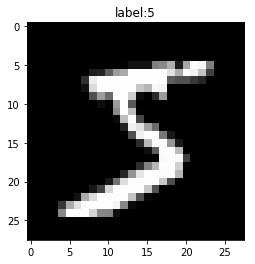

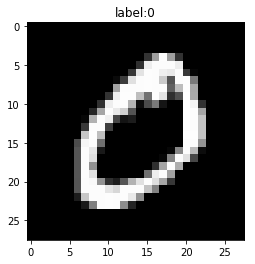

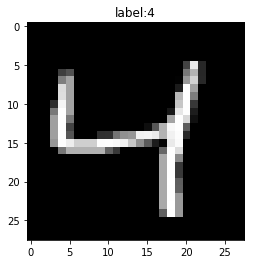

In [67]:
import matplotlib.pyplot as plt
mnist_data[0][0][0].shape
for i in range(3):
    plt.title("label:{}".format(mnist_data[i][1].numpy()))
    plt.imshow(mnist_data[i][0][0], cmap='gray', interpolation='none')
    plt.show()

In pytorch, we define our neural network by inheriting from nn.module. The forward function is the function that is called when evaluating new data

In [69]:
class MnistNetwork(nn.Module):
    def __init__(self):
        super(MnistNetwork, self).__init__()

        self.fc = nn.Sequential(nn.Linear(N_V, 1024),
                                nn.LeakyReLU(),                             
                                nn.Linear(1024,512),
                                nn.LeakyReLU(),
                                nn.Linear(512,256),
                                nn.LeakyReLU(),
                                nn.Linear(256,256),
                                nn.LeakyReLU(),
                                nn.Linear(256,128),
                                nn.LeakyReLU(),
                                nn.Linear(128,128),
                                nn.LeakyReLU(),
                                nn.Linear(128,64),
                                nn.LeakyReLU(),
                                nn.Linear(64, N_U)
                                )

    def forward(self, x):
        output = self.fc(x)
        return output

In [ ]:
network = MnistNetwork()
out = network(data[0])

we next need to define a loss function, and choose which flavour of gradient descent to use

In [70]:
# create a stochastic gradient descent optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, momentum=0.9)
# create a loss function
loss = nn.NLLLoss()

NameError: name 'optim' is not defined

In [ ]:
for i in loader(dataset):
    optimizer.zero_grad()
    out = network(x_in)
    out2 = netwowrk2(x_in2)
    loss1(out,pred)
    loss
    loss.backward()
    optimizer.step()

### Why Neural Networks?

Neural network are very flexible function estimators that learn through being shown "examples". Compared to other techniques, a strength of Neural Networks is that they can be customized to fit the structure of a dataset (Convolutional Neural Networks for images, Recurrent Neural Networks for time-series). Another advantage is that once trained, they can yield very quick predictions.

Unlike other algorithms like Support Vector Machines or Linear Regression, the loss function they minimize is not convex (ie it does not have a single minimum). Instead it has multiple minimums, and in training we are interested in finding a suitably good minimum (as opposed to a global minimum). This means that their training can sometimes be a lot more fiddly. The loss function that you minimize can also be modified to fit the task you are trying to accomplish (see VAE or GAN for example).

There is actually an interesting debate going on about whether deep learning methods should be assumption driven or whether they should be fully black-box methods. (see this open letter by max welling for example https://staff.fnwi.uva.nl/m.welling/wp-content/uploads/Model-versus-Data-AI-1.pdf)

### Neural Network Basics

Understanding how a neural network is trained requires understanding alot of moving parts here we will give a brief explanation of all the moving parts.

Neural networks are just mathematical functions approximators. By changing the weights (values associated with the edges) and activati

In [16]:
%%html
<img src="https://cdn-images-1.medium.com/max/1600/1*QVIyc5HnGDWTNX3m-nIm9w.png",width=200,height=200>

In [7]:
%%html
<img src="https://corochann.com/wp-content/uploads/2017/02/mnist_plot-800x600.png",width=200,height=200>

By varying the neural network parameters, we change the mathematical function that the neural network is representing. With small changes only slightly changing the output of the neural network.

The way we would do this with a neural network would be to:
* Create a Neural network structure and initialize it with random parameter values (weights and activation functions). For our example we want as many inputs as image pixels and as many outputs as digit choices. 

* Define a loss function which measuring how well our neural network is doing at the task (how well does it predict digits). Before the neural network is trained, the output of the neural network will be terrible.

* Iteratively, pass images through the neural network.



The aim of deep learning is, through an iterative procedure, to find a set of parameters that yield a good 

In [9]:
%%html
<img src="https://cdn-images-1.medium.com/max/1600/1*QVIyc5HnGDWTNX3m-nIm9w.png",width=200,height=200>

In [14]:
%%html
<img src="https://blog.paperspace.com/content/images/2018/05/challenges-1.png",width=10,height=10>

This picture shows the loss function with only 2 parameters. As always our intuition breaks down, neural networks will usually have tens of thousands of parameters. A minima will then only occur when all dimenions are at a minimum (otherwise saddle point). As such, its alot harder to reach a local minima. This is the same type of insight as the lottery ticket paper (see link). 